# Imports

In [1]:
# for data analysis
import numpy as np
import pandas as pd

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# for outlier capping
from scipy.stats.mstats import winsorize
import scipy.stats as stats  # Import statistical functions - used for Chi-Square

# for text pattern matching
import re

# for preprocessing
from sklearn.model_selection import train_test_split # For splitting the data into training/validation/test sets
from sklearn.pipeline import Pipeline # To create a sequential workflow of preprocessing steps
from sklearn.compose import ColumnTransformer # For applying different transformations to different columns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler # To encode categorical variables and scale numeric features

In [2]:
cost_of_living = pd.read_csv("C:/Users/barbe/OneDrive/DS Projects/Cost of Living Prediction/cost_of_living_us.csv")

# Cleaning the Dataset

In [3]:
# Drop missing values
cost_of_living = cost_of_living.dropna(subset=['median_family_income'])

# Convert all object columns to category
for col in cost_of_living.select_dtypes(include=['object']).columns:
    cost_of_living[col] = cost_of_living[col].astype('category')

# select numerical columns
num_cols = cost_of_living.select_dtypes(include=['number']).columns

In [4]:
#define function to identify outliers via IQR
def identify_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

#create dataframe to store outliers
outliers_df = pd.DataFrame()

#apply function to numerical variables
#iterate over variables
for var in num_cols:
    outliers = identify_outliers(cost_of_living, var)
    #concatenate outliers to outlier dataframe
    outliers_df = pd.concat([outliers_df, outliers])

#drop duplicate rows since some rows may be outliers in multiple columns
outliers_df = outliers_df.drop_duplicates()

In [5]:
# Define a function to cap outliers
def cap_outliers(data, column, lower_pct=0.05, upper_pct=0.95):
    data[column] = winsorize(data[column], limits=(lower_pct, 1-upper_pct))
    return data

# Apply the function to all numerical columns
for var in num_cols:
    col_clean = cap_outliers(cost_of_living, var)

In [6]:
# Function to extract parent and child counts
def extract_family_counts(family_str):
    if isinstance(family_str, str):  # Ensure the input is a string
        match = re.match(r'(\d+)p(\d+)c', family_str)  # Regex to extract numbers before 'p' and 'c'
        if match:
            num_parents = int(match.group(1))  # Extract parent count
            num_children = int(match.group(2))  # Extract child count
        else:
            num_parents, num_children = 0, 0  # Default for unexpected formats
    else:
        num_parents, num_children = 0, 0  # Handle non-string cases safely

    return num_parents, num_children

# Ensure 'family_member_count' is a string before applying the function
col_clean['family_member_count'] = col_clean['family_member_count'].astype(str)

# Apply function to create new columns
col_clean[['num_parents', 'num_children']] = col_clean['family_member_count'].apply(lambda x: pd.Series(extract_family_counts(x)))

# Create total family size column
col_clean['family_total'] = col_clean['num_parents'] + col_clean['num_children']

# Drop case_id and family_member_count columns
col_clean = col_clean.drop(columns=['case_id', 'family_member_count'])

# Modeling Implications from EDA

**Feature Selection Considerations**
- Family size (num_children and family_total) should be retained as a predictor, but only one should be included to avoid redundancy.
- Housing, food, and healthcare costs are primary drivers of total cost, making them key features for affordability analysis.
- Metro status (isMetro) is a valuable categorical variable, as it influences multiple cost categories.

**Scaling & Transformation Needs**
- Childcare, healthcare, and housing costs show high variability, indicating that log transformations or normalization may help stabilize distributions for modeling.
- Income does not correlate well with expenses, meaning that alternative affordability metrics such as cost-to-income ratio or clustering techniques may be more effective than direct regression models.

**Addressing Categorical Features**
- State is useful for location-based predictions, but county and areaname require aggregation or feature reduction due to high cardinality.
- Metro status should be encoded as a binary variable (0/1), simplifying integration into models.

**Potential Modeling Strategies**
- Linear regression models may struggle with affordability predictions, as many cost variables exhibit non-linear relationships. Nonlinear approaches such as decision trees, random forests, or clustering-based models may yield better results.
- Regional clustering may help simplify high-cardinality categorical variables like areaname and county while retaining geographic insights.
- Consider interaction terms, such as num_children * childcare_cost, to capture dependencies between family size and financial burdens

# Master Preprocessing

Since we'll be doing regression models and clustering models, there are different methods of preprocessing that we'll need to consider. To this end, we'll first do a 'master' preprocessing - that is, preprocessing that both types of models share. Then we'll do separate preprocessing for each model type.

## Feature Selection & Redundancy Removal

### Dropping Features

To optimize our dataset for regression and clustering models, we are dropping features that introduce redundancy or have low predictive value based on EDA findings.
- county and areaname have high cardinality and are strongly dependent on state, meaning keeping all three would introduce redundancy. Since state is more manageable for categorical encoding, we drop county and areaname to simplify geographic representation.
- num_children is highly correlated with family_total (0.94 - 0.95). Since family_total already includes the number of children and parents, keeping both would create duplication without adding extra value. We retain family_total and drop num_children.
- num_parents showed low correlations with household expenses, meaning it does not significantly impact costs like housing, food, or childcare. Since family_total captures household size, num_parents is redundant and is being dropped.

In [7]:
# List of features to drop
features_to_drop = ["county", "areaname", "num_children", "num_parents"]

# Remove unnecessary columns from the dataset
col_clean = col_clean.drop(columns=features_to_drop)

# Confirm removal by displaying remaining features
print("Remaining Features After Dropping Redundant Variables:")
col_clean.columns

Remaining Features After Dropping Redundant Variables:


Index(['state', 'isMetro', 'housing_cost', 'food_cost', 'transportation_cost',
       'healthcare_cost', 'other_necessities_cost', 'childcare_cost', 'taxes',
       'total_cost', 'median_family_income', 'family_total'],
      dtype='object')

### Keeping Features

After analyzing the dataset through EDA, we have carefully chosen the features that provide meaningful insights while eliminating redundancy. Below is a structured breakdown of the variables we are keeping and why they are important for our modeling objectives.
- Housing cost: A primary driver of total household expenses and one of the most variable costs across metro and non-metro areas.
- Food cost: A major recurring expense highly correlated with family size and total cost.
- Transportation cost: While showing moderate correlations with other expenses, it remains a significant financial burden and is useful for affordability analysis.
- Healthcare cost: Exhibits high variability and can help assess medical affordability trends.
- Childcare cost: A significant financial pressure for families, especially in metro areas, making it a critical affordability factor.
- Other necessities cost: Represents essential living expenses outside of housing, transportation, and childcare.
- Taxes: While weakly correlated with household expenses, it may provide insights into geographic tax burdens.
- Total cost: The primary dependent variable for regression models assessing overall financial burden.
- Median family income: A key affordability indicator that, despite weak correlations with expenses, may benefit from transformations for modeling.
- Family total: Represents the entire household size, making it more informative than num_children or num_parents alone.
- State: Retained as the primary geographic identifier for location-based analysis, replacing county and areaname.
- IsMetro: A critical categorical feature influencing household expenses; it will be converted into a binary variable for modeling.

## Handling Skewed Numerical Features

Since housing cost, taxes, and median family income exhibit clear right skewness (Histogram from EDA), applying a log transformation will help stabilize their variance and make them more suitable for regression models.

In [8]:
# Apply natural log transformation to right-skewed features
skewed_features = ["housing_cost", "taxes", "median_family_income"]
for feature in skewed_features:
    col_clean[feature + "_log"] = np.log1p(col_clean[feature])  # log(1 + x) to handle zero values safely

# Drop the original skewed columns to avoid redundancy
col_clean = col_clean.drop(columns=skewed_features)

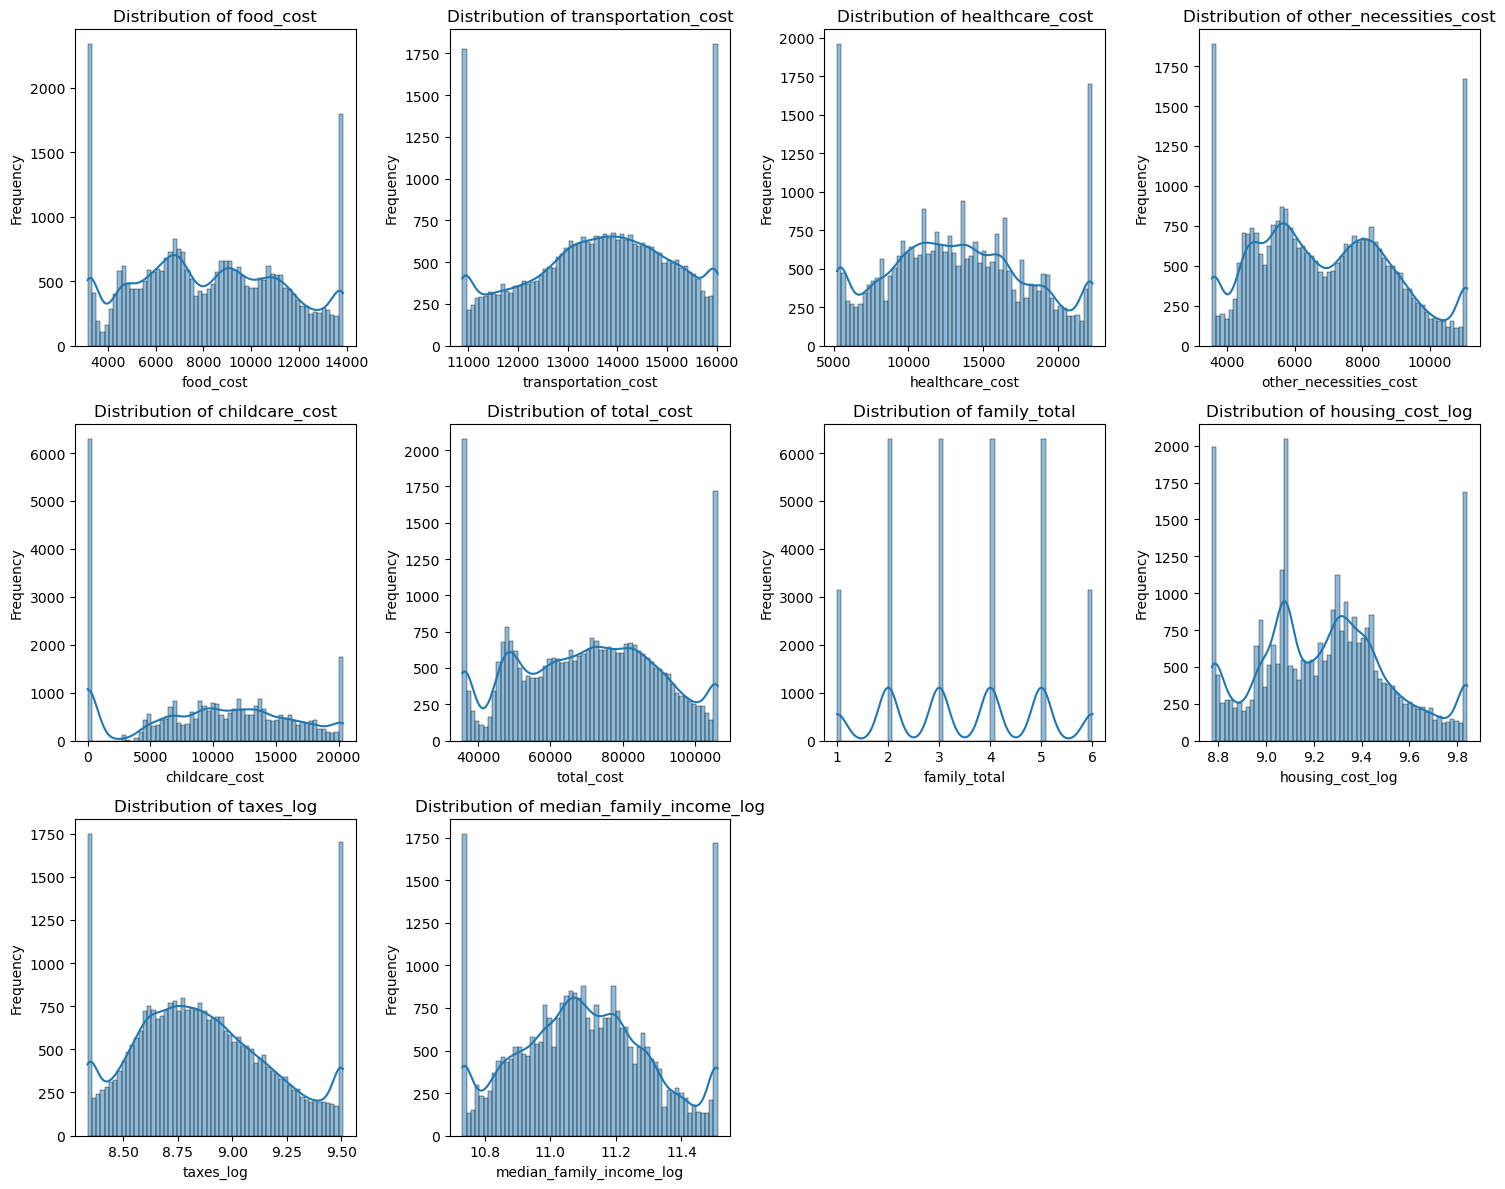

In [9]:
# Select numerical columns in the dataset after our transformations
num_cols = col_clean.select_dtypes(include=['number']).columns

# Define number of rows and columns for the subplot grid dynamically
cols = min(len(num_cols), 4)  # Limit to a maximum of 4 columns for a neat layout
rows = (len(num_cols) // 4) + (1 if len(num_cols) % 4 != 0 else 0)

# Create the subplots for visualization
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, rows * 4))
axes = axes.flatten()  # Flatten the array for easy iteration

# Iterate over numerical variables and plot histograms with KDE
for i, var in enumerate(num_cols):
    sns.histplot(col_clean[var], bins=60, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frequency')

# Remove any unused axes if the total number of subplots exceeds the number of variables
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- The distribution for housing_cost_log is now concentrated between roughly 8.8 and 9.8, which suggests that the log transformation has reduced the right-skew and compressed the range into a more compact, almost normal distribution.
- Similarly, taxes_log now falls between about 8.5 and 9.5. This indicates that the skewness for taxes has been tamed, making further scaling easier down the road.
- The median_family_income_log distribution shows values between approximately 10.8 and 11.4. This confirms that the transformation helped normalize its distribution, possibly making it more effective in regression modeling by stabilizing the variance

## Handling Boolean Features

- Converted isMetro from a boolean flag to a numeric binary feature (True:1, False:0) so that every column in our dataset is numeric and immediately consumable by modeling algorithms.
- Saved the result as master_df—a snapshot of our fully cleaned baseline dataset that we can reliably branch off into separate, model‐specific preprocessing pipelines without ever altering the core cleaned data.

In [10]:
# Convert boolean to binary (0/1)
col_clean["isMetro"] = col_clean["isMetro"].astype(int)

# Save the result as the “master” cleaned dataset
master_df = col_clean.copy()

# 3. Quick check
print(f"Master dataset shape: {master_df.shape}")
print(master_df.dtypes)
master_df.head()

Master dataset shape: (31420, 12)
state                       category
isMetro                        int32
food_cost                    float64
transportation_cost          float64
healthcare_cost              float64
other_necessities_cost       float64
childcare_cost               float64
total_cost                   float64
family_total                   int64
housing_cost_log             float64
taxes_log                    float64
median_family_income_log     float64
dtype: object


,state,isMetro,food_cost,transportation_cost,healthcare_cost,other_necessities_cost,childcare_cost,total_cost,family_total,housing_cost_log,taxes_log,median_family_income_log
0,AL,1,3454.91712,10876.68600,5737.47984,4333.81344,0.0000,39254.0532,1,9.048613,8.763107,11.198371
1,AL,1,5091.70788,11588.19288,8659.55640,6217.45896,6147.8298,57194.3256,2,9.398354,8.912349,11.198371
2,AL,1,7460.20308,12361.77720,11581.63260,7075.65816,15824.6940,76141.0308,3,9.398354,9.187129,11.198371
3,AL,1,9952.23924,13452.18600,14503.70760,9134.35620,18802.1892,94203.5328,4,9.632869,9.480574,11.198371
4,AL,1,12182.21400,13744.59840,17425.78560,9942.36396,18802.1892,100823.5200,5,9.632869,9.507878,11.198371


# Regression Model Preprocessing

Pipeline steps:
- Separate features and target
- Split the dataset
- Identify categorical and numiercal features
- Build preprocessing pipeline
- Fit and transform the dataset
- Verify processed datasets

In [11]:
# Create a separate copy of master_df for the regression pipeline
df_reg = master_df.copy()   # df_reg will be used for regression-specific preprocessing and modeling

Here, we split our master dataset (master_df) into two parts:
- X: the predictors (all features except total_cost), and
- y: the target variable (total_cost), which is what the regression model will try to predict.

In [12]:
# Separate predictors and the target
X = df_reg.drop(columns=["total_cost"]) # X contains all predictor variables
y = df_reg# Create a separate copy of master_df for the clustering pipeline

We first split our data into 70% training and 30% leftover. From the temporary 30%, we split it such that approximately 20% goes to validation and 10% to final testing. This gives us:
- 70% Training
- 20% Validation
- 10% Testing

In [13]:
# Split the dataset: 70% for training and 30% for temporary (validation + test) set.
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.70, random_state=12)

# Further split the temporary set into validation (20%) and test (10%) sets.
X_val, X_test, y_val, y_test = train_test_split( X_temp, y_temp, test_size=1/3, random_state=12)

We define which features are categorical (here, only state) and treat all other columns as numeric. This is needed so that we can apply the appropriate data transformations to each type.

In [14]:
# Identify the categorical and numeric features in the training data.
categorical_feats = ["state"] # List of categorical features: in this case only 'state' remains
numeric_feats = [col for col in X_train.columns if col not in categorical_feats]  # Every other column is numeric

Preprocessing:
- OneHotEncoder: We encode the state categorical feature into dummy/binary columns. Dropping the first category prevents redundancy (known as dummy variable trap).
- StandardScaler: We scale the numeric features (all features other than state) so they have zero mean and unit variance.
- ColumnTransformer: Combines these transformations, applying each to its respective set of columns.

In [15]:
# Build a ColumnTransformer to process different columns:
preprocessor = ColumnTransformer(
    transformers=[
        # OneHotEncode the 'state' column; drop the first category to avoid collinearity
        ("state_ohe", OneHotEncoder(drop="first"), categorical_feats),
        # Standardize the numeric features using StandardScaler
        ("num_scale", StandardScaler(), numeric_feats)
    ],
    remainder="drop"  # This ensures any columns not specified are dropped
)

The Pipeline encapsulates our preprocessing steps. This makes it easier to:
- Fit the transformations on training data only.
- Apply the same learned transformations to validation and testing sets. This approach maintains consistency between the datasets, ensuring that no information leaks from the validation or test sets during model training.

In [16]:
# Wrap the ColumnTransformer in a Pipeline so that we can sequentially call the preprocessing step,
# and potentially extend it with further steps (like adding a model later).
reg_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor)  # The pipeline consists solely of our preprocessor for now
])

- fit_transform on X_train: Learns the necessary transformations (like calculating mean and standard deviation for numeric features) from the training data, then applies them.
- transform on X_val and X_test: Uses the same learned parameters from the training step to transform the validation and test data—keeping these steps free from data leakage.

In [17]:
# Fit the pipeline on the training data and transform the training set.
X_train_prep = reg_pipeline.fit_transform(X_train, y_train)

# Apply the fitted pipeline to transform the validation set.
X_val_prep = reg_pipeline.transform(X_val)

# Apply the same transformation to the test set.
X_test_prep = reg_pipeline.transform(X_test)

Finally, we print the shapes of the transformed training, validation, and test datasets. Verifying these shapes confirms that our splits are correct and that the preprocessing steps have been successfully applied to each subset.

In [18]:
# Print the shapes of the processed datasets to ensure splits and transforms worked as expected.
print("Shape of preprocessed training data:", X_train_prep.shape)  # Should correspond to 70% of samples and new feature count
print("Shape of preprocessed validation data:", X_val_prep.shape)    # Should correspond to 20% of samples and new feature count
print("Shape of preprocessed test data:", X_test_prep.shape)         # Should correspond to 10% of samples and new feature count

Shape of preprocessed training data: (21994, 60)
Shape of preprocessed validation data: (6284, 60)
Shape of preprocessed test data: (3142, 60)


We are now ready for regression modeling!

# Clustering Model Preprocessing

**Clustering Pipeline Steps**
- Group states into broader regions
- Apply mapping to dataset
- Identify categorical and numerical features
- Build clustering preprocessing pipeline
- Apply the clustering pipeline to dataset

In [19]:
# Create a separate copy of master_df for the clustering pipeline
df_clust = master_df.copy() # df_clust will be used for clustering-specific preprocessing and analysis

# Drop the target variable 'total_cost' from the clustering DataFrame
df_clust = df_clust.drop(columns=["total_cost"])

We'll first create a function that groups the detailed state abbreviations into broader regions (for example, based on US Census regions). This helps reduce dimensionality and provide meaningful groupings for clustering.
- This function takes a state abbreviation and returns the corresponding region (e.g., "Northeast", "Midwest").
- Grouping the 51 states into a smaller number of regions reduces the dimensionality when encoding and helps clustering algorithms work with fewer, more general categories.

In [20]:
def map_state_to_region(state):
    """
    Map a US state abbreviation (or 'DC') to one of the four US Census regions.
    
    Regions defined as:
    - Northeast: CT, ME, MA, NH, RI, VT, NJ, NY, PA
    - Midwest: IL, IN, MI, OH, WI, IA, KS, MN, MO, NE, ND, SD
    - South: DE, DC, FL, GA, MD, NC, SC, VA, WV, AL, KY, MS, TN, AR, LA, OK, TX
    - West: AK, AZ, CA, CO, HI, ID, MT, NV, NM, OR, UT, WA, WY
    """
    
    # Northeast
    if state in ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NJ', 'NY', 'PA']:
        return 'Northeast'
    # Midwest
    elif state in ['IL', 'IN', 'MI', 'OH', 'WI', 'IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD']:
        return 'Midwest'
    # South (includes the District of Columbia, plus states from both the South Atlantic, East South Central, and West South Central)
    elif state in ['DE', 'DC', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 'WV',
                   'AL', 'KY', 'MS', 'TN', 'AR', 'LA', 'OK', 'TX']:
        return 'South'
    # West
    elif state in ['AK', 'AZ', 'CA', 'CO', 'HI', 'ID', 'MT', 'NV', 'NM', 'OR', 'UT', 'WA', 'WY']:
        return 'West'
    # If for some reason a state is not matched, return 'Other'
    else:
        return 'Other'

Next, we apply the mapping function to our clustering DataFrame (df_clust) to create a new region column based on the state column.
- Here we add the new column "region" to df_clust by applying our map_state_to_region function to every entry in the state column.
- Optionally, if you no longer need the detailed "state" column for clustering, you can drop it to avoid redundancy.

In [21]:
# Apply the mapping function to create a new 'region' column in df_clust
df_clust["region"] = df_clust["state"].apply(map_state_to_region)

# Drop the state column
df_clust = df_clust.drop(columns=["state"])

We now define which features should be treated as categorical and which as numeric in our clustering pipeline.
- Setting categorical_feats_clust as ["region"] tells us that for clustering purposes, we only want to encode the broader region information.
- All other numeric columns in df_clust will be scaled since clustering algorithms are sensitive to the scale when computing distances.

In [22]:
# For clustering, we will encode the 'region' column as our categorical feature.
categorical_feats_clust = ["region"]

# Identify numeric features: we grab all numeric columns from df_clust.
# This typically includes cost features, family totals, isMetro (already converted to 0/1), etc.
numeric_feats_clust = [col for col in df_clust.select_dtypes(include=["number"]).columns]

We create a ColumnTransformer that applies one-hot encoding to the region column and normalizes all numeric features to a 0–1 range using MinMaxScaler.
- OneHotEncoder: Transforms the categorical "region" column into binary dummy variables.
- MinMaxScaler: Transforms numeric features by scaling them to the 0–1 range, ensuring that no feature dominates the distance computations.
- The ColumnTransformer groups these transformations, applying each to its designated set of columns.

In [23]:
# Build a ColumnTransformer for clustering:
cluster_preprocessor = ColumnTransformer(
    transformers=[
        # OneHot encode the 'region' feature. Here we do not drop a category since in clustering,
        # having all encoded features is typically acceptable.
        ("region_ohe", OneHotEncoder(), categorical_feats_clust),
        # Normalize the numeric features to the [0, 1] range using MinMaxScaler.
        ("num_minmax", MinMaxScaler(), numeric_feats_clust)
    ],
    remainder="drop"  # Drop any columns not explicitly listed (ensures clean transformation)
)

Next, we wrap the ColumnTransformer inside a Pipeline. This encapsulates all our preprocessing steps into a single, reusable object.
- The Pipeline lets us call fit_transform on our data so that all necessary transformations are applied sequentially.
- This approach simplifies applying the same processing sequence to future data without repeating each step manually.

In [24]:
# Wrap the ColumnTransformer into a Pipeline.
clust_pipeline = Pipeline(steps=[
    ("clust_preprocessing", cluster_preprocessor)  # Our pipeline currently consists of just the column transformer.
])

Since clustering usually works on the entire dataset without splitting into train/test, we fit our pipeline on the complete clustering DataFrame (df_clust)
- fit_transform() on df_clust computes the necessary parameters (e.g., the min and max for each numeric feature) and then applies those transformations.
- The output, stored in X_cluster, is a numeric array ready for input into a clustering algorithm (like K-Means).
- Printing the shape helps ensure that the expected dimensions (number of rows and new feature columns) have been generated.

In [25]:
# Fit the clustering pipeline on the complete DataFrame and transform the data.
X_cluster = clust_pipeline.fit_transform(df_clust)

# Print the shape of the transformed dataset to verify that the transformation was successful.
print("Shape of the clustering-preprocessed dataset:", X_cluster.shape)

Shape of the clustering-preprocessed dataset: (31420, 15)
